## PandExo: A community tool for transiting exoplanet science with JWST & HST
### Similar to an exposure time calculator (ETC), PandExo is a transiting exoplanet noise simulator.  It is based on Pandeia, the ETC for JWST, and has been expanded to include HST's WFC3 instrument.
This tutorial demonstrates how to use PandExo to:
    1. Optimize WFC3's NSAMP and SAMP-SEQ parameters,
    2. Predict transmission/emission spectrum uncertainties, and
    3. Determine the observation start window
for any system observed with HST/WFC3 using the G102 & G141 grisms.  The current implementation scales the measured WFC3 flux and variance from existing observations and has been shown to be reliable against previously-published results.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os, sys
sys.path.append('../engine')
import HST_TExoNS as hst

## Step 1) Load in a exoplanet and instrument dictionaries
- WFC3 G102
- WFC3 G141

In [2]:
exo_dict  = hst.load_exo_dict()
inst_dict = hst.load_mode_dict('WFC3 G141')

Replace all inputs before calling run_pandexo.


## Step 2) Edit inputs
#### For this tutorial, we will simulate uncertainties for the WASP-43 system

In [3]:
#WASP-43
exo_dict['star']['hmag']      = 9.397                          # H-band magnitude of the system
#WASP-43b
exo_dict['planet']['exopath'] = 'WASP43b-Eclipse_Spectrum.txt' # filename for model spectrum [wavelength, flux]
exo_dict['planet']['w_unit']  = 'um'                           # wavelength unit (um or nm)
exo_dict['planet']['f_unit']  = 'fp/f*'                        # flux unit (fp/f* or (rp/r*)^2)
exo_dict['planet']['depth']   = 4.0e-3                         # Approximate transit/eclipse depth for plotting purposes
exo_dict['planet']['i']       = 82.6                           # Orbital inclination in degrees
exo_dict['planet']['ars']     = 5.13                           # Semi-major axis in units of stellar radii (a/R*)
exo_dict['planet']['period']  = 0.8135                         # Orbital period in days   

### Edit HST/WFC3 detector and observation inputs

In [4]:
exo_dict['calculation'] = 'scale'
inst_dict['configuration']['detector']['subarray']     = 'GRISM256'   # Subarray size, GRISM256 or GRISM512
inst_dict['configuration']['detector']['nsamp']        = 10           # WFC3 NSAMP, 1..15
inst_dict['configuration']['detector']['samp_seq']     = 'SPARS5'     # WFC3 SAMP-SEQ, SPARS5, SPARS10, or SPARS25
exo_dict['observation']['transit_duration']            = 4170         # Full transit/eclipse duration in seconds
exo_dict['observation']['norbits']                     = 4            # Number of HST orbits per visit
exo_dict['observation']['noccultations']               = 5            # Number of transits/eclipses
exo_dict['observation']['nchan']                       = 15           # Number of spectrophotometric channels
exo_dict['observation']['scanDirection']               = 'Forward'    # Spatial scan direction, Forward or Round Trip
exo_dict['observation']['schedulability']              = '30'         # % time HST can observe target (30 or 100)

## Step 3) Run PandExo

In [5]:
foo = hst.run_pandexo(exo_dict, inst_dict, output_file='wasp43b_G141.p')

Running Single Case w/ User Instrument Dict.
****WARNING: Observing plan may incur mid-orbit buffer dumps.  Check with APT.
Number of HST orbits: 4
WFC3 parameters: NSAMP = 10, SAMP_SEQ = SPARS5
Recommended scan rate: 0.076 arcsec/s
Scan height: 13.5 pixels
Maximum pixel fluence: 30266 electrons
Estimated duty cycle (outside of Earth occultation): 25.0%
Transit depth uncertainty: 62.4 ppm for each of 15 channel(s)


### Note the warning in the output indicating the potential for mid-orbit buffer dumps.  To avoid such warnings, WFC3's NSAMP and SAMP-SEQ parameters can be optimized by setting their values to None.

In [6]:
inst_dict['configuration']['detector']['nsamp'] = None
inst_dict['configuration']['detector']['samp_seq'] = None
bar = hst.run_pandexo(exo_dict, inst_dict, output_file='wasp43b_G141.p')

Running Single Case w/ User Instrument Dict.
Number of HST orbits: 4
WFC3 parameters: NSAMP = 7, SAMP_SEQ = SPARS25
Recommended scan rate: 0.076 arcsec/s
Scan height: 84.4 pixels
Maximum pixel fluence: 30266 electrons
Estimated duty cycle (outside of Earth occultation): 58.2%
Transit depth uncertainty: 40.9 ppm for each of 15 channel(s)


### In this case, the best values are NSAMP = 7 and SAMP-SEQ = SPARS25.  The observations can be further optimized by using the 'Round Trip' mode to avoid pointing overheads.  For comparison, let's also select the NSAMP and SAMP-SEQ values that were used in the actual observation.

In [7]:
inst_dict['configuration']['detector']['nsamp']        = 15
inst_dict['configuration']['detector']['samp_seq']     = 'SPARS10'
exo_dict['observation']['scanDirection']               = 'Round Trip'
deptherr, rms, ptsOrbit = hst.run_pandexo(exo_dict, inst_dict, output_file='wasp43b_G141.p')

Running Single Case w/ User Instrument Dict.
Number of HST orbits: 4
WFC3 parameters: NSAMP = 15, SAMP_SEQ = SPARS10
Recommended scan rate: 0.076 arcsec/s
Scan height: 64.8 pixels
Maximum pixel fluence: 30266 electrons
Estimated duty cycle (outside of Earth occultation): 68.8%
Transit depth uncertainty: 37.6 ppm for each of 15 channel(s)


## Step 4) Plot Results

### Plot model spectrum with simulated data and uncertainties

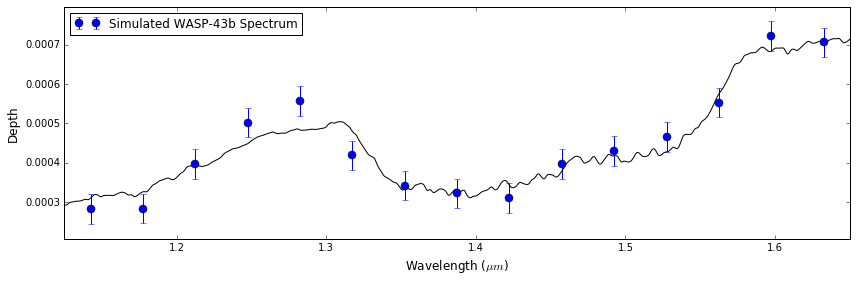

In [8]:
specfile   = exo_dict['planet']['exopath']
w_unit     = exo_dict['planet']['w_unit']
grism      = inst_dict['configuration']['instrument']['disperser']
nchan      = exo_dict['observation']['nchan']
hst.plot_PlanSpec(specfile, w_unit, grism, deptherr, nchan, smooth=10)

### Compare simulation to published results

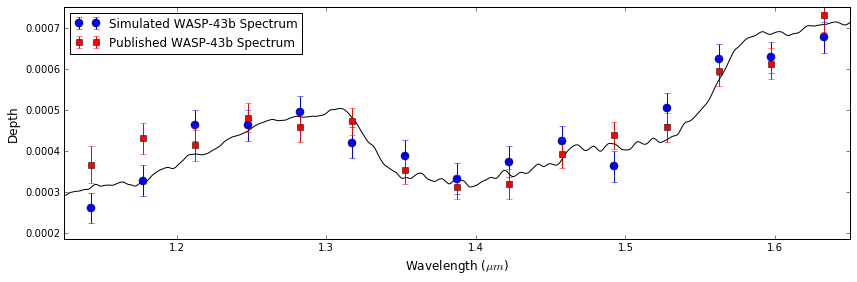

In [9]:
import cPickle as pickle
handle  = open('./PHASE7_WFC3_IRAC_spectra.pic')
model   = pickle.load(handle)
hst.plot_PlanSpec(specfile, w_unit, grism, deptherr, nchan, smooth=20)
plt.errorbar(model[0],model[1],model[2],fmt='rs', label='Published WASP-43b Spectrum')
leg=plt.legend(loc='upper left')

In [10]:
print("Simulated uncertainty: %0.1f ppm" % (deptherr*1e6))
print("Mean published uncertainty: %0.1f +/- %0.1f ppm" % (np.mean(model[2][:15])*1e6,np.std(model[2][:15])*1e6))
print("Results are consistent at %0.1f sigma." % ((deptherr-np.mean(model[2][:15]))/np.std(model[2][:15])))

Simulated uncertainty: 37.6 ppm
Mean published uncertainty: 36.5 +/- 3.5 ppm
Results are consistent at 0.3 sigma.


## Step 5) Compute earliest and latest possible start times for given start window size

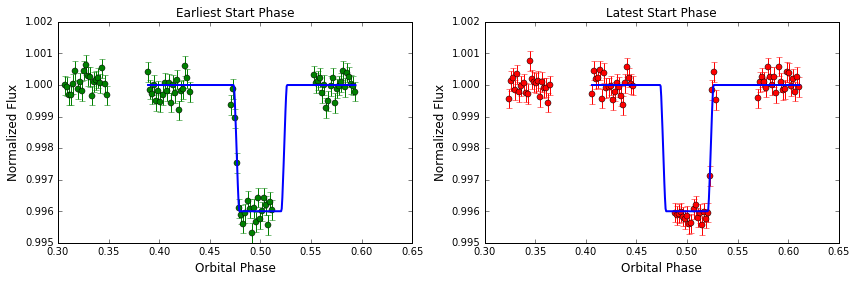

In [14]:
numorbits = exo_dict['observation']['norbits']
depth     = exo_dict['planet']['depth']
inc       = exo_dict['planet']['i']
aRs       = exo_dict['planet']['ars']
period    = exo_dict['planet']['period']
windowSize= 20                                  # observation start window size in minutes
reload(hst)
minphase, maxphase = hst.calc_StartWindow('eclipse', rms, ptsOrbit, numorbits, depth, inc, 
                                          aRs, period, windowSize, ecc=0, w=90.)
plt.savefig('WASP43b-StartWindow.eps')

In [15]:
print("Start observations between orbital phases: %0.4f - %0.4f" % (minphase, maxphase))

Start observations between orbital phases: 0.3071 - 0.3241
